### Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


### 读取Mnist数据集
- 会自动进行下载

In [2]:
%matplotlib inline

In [3]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [4]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

784是mnist数据集每个样本的像素点个数

(50000, 784)
5


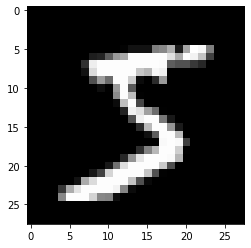

In [5]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)
print(y_train[0])

注意数据需转换成tensor才能参与后续建模训练


In [6]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### torch.nn.functional 很多层和函数在这里都会见到

torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些

In [7]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb.mm(weights) + bias

In [8]:
bs = 64
xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype = torch.float,  requires_grad = True) 
bs = 64
bias = torch.zeros(10, requires_grad=True)

print(loss_func(model(xb), yb))

tensor(14.8359, grad_fn=<NllLossBackward0>)


### 创建一个model来更简化代码

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [9]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out  = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x
        

In [10]:
net = Mnist_NN()
print(net)


Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


可以打印我们定义好名字里的权重和偏置项

In [11]:
for name, parameter in net.named_parameters():
    print(name, parameter,parameter.size())

hidden1.weight Parameter containing:
tensor([[ 3.3924e-02,  2.8203e-02,  7.4763e-03,  ...,  1.2120e-02,
         -3.1068e-02, -2.6079e-02],
        [-1.9429e-02,  3.4990e-02, -1.2515e-02,  ...,  1.0827e-02,
         -1.9339e-02,  1.7851e-02],
        [ 1.7933e-03, -1.6740e-02, -8.8343e-03,  ..., -7.9636e-05,
          1.8105e-02,  1.4471e-02],
        ...,
        [ 2.4911e-02, -2.3699e-02,  3.3719e-02,  ..., -3.4438e-02,
         -1.0813e-02,  3.4444e-02],
        [ 3.1036e-02, -1.6719e-02,  1.2127e-02,  ...,  9.0826e-03,
         -1.2473e-02, -1.2882e-02],
        [ 3.2334e-02, -1.0435e-02, -6.0367e-03,  ...,  2.9114e-02,
         -3.1620e-02, -2.8967e-04]], requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([ 0.0105, -0.0028,  0.0022,  0.0102, -0.0204, -0.0241,  0.0161,  0.0071,
         0.0260,  0.0242,  0.0216, -0.0096, -0.0130, -0.0237, -0.0160,  0.0052,
        -0.0199,  0.0168,  0.0141,  0.0224, -0.0355,  0.0306,  0.0176,  0.0253,
        -0.02

### 使用TensorDataset和DataLoader来简化

In [12]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [13]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [14]:
import numpy as np

def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))

In [15]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [16]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

### 三行搞定！

In [17]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(25, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：2.280521762084961
当前step:1 验证集损失：2.2493453804016115
当前step:2 验证集损失：2.199923737716675
当前step:3 验证集损失：2.11922739982605
当前step:4 验证集损失：1.9896063777923585
当前step:5 验证集损失：1.7941044673919677
当前step:6 验证集损失：1.5410480503082276
当前step:7 验证集损失：1.2829019281387328
当前step:8 验证集损失：1.0695147428512572
当前step:9 验证集损失：0.9111745872497559
当前step:10 验证集损失：0.7951208155632019
当前step:11 验证集损失：0.708297229385376
当前step:12 验证集损失：0.6416949621200562
当前step:13 验证集损失：0.5893908842086792
当前step:14 验证集损失：0.547949939584732
当前step:15 验证集损失：0.5144602170467377
当前step:16 验证集损失：0.4868099680900574
当前step:17 验证集损失：0.4642222202301025
当前step:18 验证集损失：0.445196675491333
当前step:19 验证集损失：0.42932558765411377
当前step:20 验证集损失：0.4155343008995056
当前step:21 验证集损失：0.4032670767068863
当前step:22 验证集损失：0.39361734399795534
当前step:23 验证集损失：0.3847621057033539
当前step:24 验证集损失：0.3760298326253891


[ 2.6018794  -6.568608    2.013435   -1.7659931   1.2831159   1.218706
  5.6075215  -2.8065872  -1.0922228  -0.43885943]
6


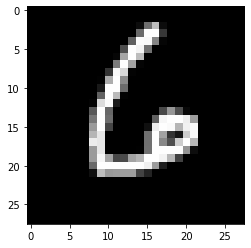

In [27]:
index = 2
pyplot.imshow(x_valid[index].reshape((28, 28)), cmap="gray")
print(model(x_valid[index]).detach().numpy())
print(y_valid[index].numpy())